In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/Github/Biometric

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Github/Biometric


In [ ]:
#!zip -r datanew.zip Template_poisoning/Croped_data

In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

import seaborn as sns
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt
import cv2
from PIL import Image

from FUNC_script import *

## # Load FaceNet Model

In [ ]:
model = load_model('Template_poisoning/model/facenet_keras.h5', compile= False)
model.trainable= False

In [ ]:
#model.layers[-2].get_config() 'activation- linear'
#model.layers[-1].get_config() 'batchnorm'

In [ ]:
# Read Images (160x160x3)
def load_img(path, resize=None):
    img= Image.open(path)
    img= img.convert('RGB')
    if resize is not None:
        img= img.resize((resize, resize))
    return np.asarray(img)

def Centroid(vector):
  ''' 
      After the random initialization, we first optimize the
      glasses using the adversary’s centroid in feature space(Xc)
     # Arguments
        Input: feature vector(batch_size x feature)	
    '''
  Xc= tf.math.reduce_mean(vector, axis=0)
  return tf.reshape(Xc, (1, vector.shape[-1]))

### Data  Loading

In [ ]:
def load_data(dir):
  X=[]
  for i, sample in enumerate(os.listdir(dir)):
    image= load_img(os.path.join(dir, sample))
    image = cv2.resize(image, (160, 160))
    X.append(image/255.0)
  return np.array(X)

X= load_data('Template_poisoning/Croped_data/adversary_images')
Target_samples= load_data('Template_poisoning/Croped_data/target_images')
X_ex= X.copy() # Copy of X

print('Adversarial Batch:',X.shape)
print('Target Batch:',Target_samples.shape)

Adversarial Batch: (46, 160, 160, 3)
Target Batch: (75, 160, 160, 3)


In [ ]:
# GET Mask
mask= load_img('Template_poisoning/final_mask.png') #Sacle(0-255), RGB
mask= mask/255.0
mask.shape

(160, 160, 3)

### Get Predictions

In [ ]:
# img_tr= load_img('Template_poisoning/Croped_data/target_images/ben_afflek_0.jpg')
# feature_tr= model.predict(img_tr[np.newaxis, :, :, :])
#Target= Generate_target(feature_tr, batch_size= X.shape[0])

Targetc= Centroid(model.predict(Target_samples))
Targetc.shape

TensorShape([1, 128])

In [ ]:
Xc= Centroid(model.predict(X)) #(1 x 128)
print(Xc.shape)

(1, 128)


In [ ]:
delta_x= np.random.uniform(low=0.0, high=1.0, size=X.shape) # Scale(0-1)
delta_x.shape

(46, 160, 160, 3)

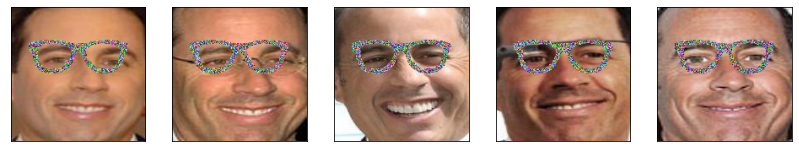

In [ ]:
f, ax= plt.subplots(1, 5, figsize=(14, 4))
image= X*(1-mask)+ delta_x*mask
for i in range(5):
  ax[i].imshow(image[i+5])
  ax[i].set_xticks([]); ax[i].set_yticks([])
plt.show()
del image

## Random Distance Method

Conditions:
* Target's cancelable biometric identity revealed 
* Target's Stolen Token= 6

In [ ]:
def salt_2dim(X):
    samples, features= X.shape
    X_out= np.zeros((samples,features//2, 2))
    for i, x in enumerate(X):
        X_out[i,:, 0]= x[:features//2]
        X_out[i,:, 1]= x[features//2:]
    return X_out

def shuffle(X_vec, p=4, seed= 0, with_seed= True):
    for X in X_vec:
        j= 64+p
        for i in np.arange(p, j, p):
            x= X[(i-p):i]
            if with_seed:
                np.random.seed(seed)
            np.random.shuffle(x[:8])
    return X_vec



# For Tensors
def shuffle_tesnsor(X_vec, p=4, seed= 0, with_seed= True):
    for X in X_vec:
        j= 64+p
        for i in np.arange(p, j, p):
            x= X[(i-p):i]
            if with_seed:
                tf.random.set_seed(seed)
            tf.random.shuffle(x)
    return X_vec

In [ ]:
def get_RDM(Fv, token=6, c=100):
    '''
    INPUT---
    Fv.shape: (None, feature)
    token: Uses token key
    PROCESS---
    1. Feature vector(Fv) multiplied by a large constant, say c = 100 due to its low dynamic range.
    2. To increase the entropy of the template, fv is salted by ORing it with a random grid RG as fs = fv + RG.
    3. Fv is divided into two equal parts.
    4. A user-specific key (K) of dimension 1 × N is generated, 
    which has randomly distributed non-integral values in the range [−100, 100].
    5. Computation of distance via random feature vectors.
    6. In order to provide noninvertibility, median filtering is applied on distance vector D
    to generate transformed feature vector T f , where the intensity
    values are shuffled in p ×1 neighborhood. T f is stored as the
    final transformed template.
    OUTPUT---
    Out.shape: (None, feature//2)
    '''
    #1
    Fv*= c
    #2
    np.random.seed(token)
    Fv+= np.random.randint(1, 256, size= Fv.shape)
    #3
    Fv= salt_2dim(Fv)
    #4
    np.random.seed(token)
    K= np.random.randint(-100, 101, size= (1, Fv.shape[-1]))
    #5
    dist =(Fv- K)**2
    dist= np.sqrt(np.sum(dist, 2))
    #6
    Tf= shuffle(dist.copy(), p=4, seed= token, with_seed= True)
    return Tf


#for tensors
def RDM_tf(Fv, token=6, c=100.0):
  #Fv= tf.Variable(Fv, dtype=tf.float64)
  Fv+=c

  tf.random.set_seed(token)
  Fv+= tf.random.uniform(
      Fv.shape, minval=1, maxval=256, dtype=tf.dtypes.float64, seed=None, name=None)
  
  Fv= tf.convert_to_tensor(salt_2dim(Fv))
  tf.random.set_seed(token)
  K= tf.random.uniform((1, Fv.shape[-1]), minval=-101, maxval=101, dtype=tf.dtypes.float64, seed=None, name=None)

  dist =(Fv- K)**2
  dist= tf.math.sqrt(tf.math.reduce_sum(dist, 2))

  return shuffle_tesnsor(dist, p=4, seed= token, with_seed= True)

In [ ]:
Targetc.shape, Xc.shape

(TensorShape([1, 128]), TensorShape([1, 128]))

In [ ]:
Targetc= get_RDM(Targetc)
Targetc= Generate_target(Targetc, batch_size= X.shape[0])
Targetc.shape

(46, 64)

In [ ]:
Xc= get_RDM(Xc)
Xc= Generate_target(Xc, batch_size=X.shape[0]) #(46 x 128)
Xc.shape

(46, 64)

## Back propagation and Loss Pipeline

In [ ]:
def loss_object(pred, label, delta= delta_x, direction= False):
  # Loss= euclidean distance + Delta_x pixel Variance
  dist= Euclidean_dist(pred, label)
  variance= Sample_variance(delta_x)
  if direction:
    sc= tf.math.subtract(1.0, tf.math.divide(1.0, label.shape[0]))
    #print(dist.shape, sc.shape)
    vector_mean= dist* tf.cast(sc, dist.dtype) #tf.math.multiply(dist, sc)
   
    target_dir= tf.math.multiply(vector_mean, dist)
    Loss= tf.math.add(target_dir, tf.cast(variance, dist.dtype))
    return Loss

  Loss= tf.math.add(tf.cast(dist, variance.dtype), variance)
  return Loss

In [ ]:
def back_propagate(model, X, mask, delta_x, label, direction= False):
  with tf.GradientTape() as g:
      g.watch(delta_x)
      X_batch= Generate_sample(X, delta_x, mask)
      feature= tf.cast(model(X_batch), tf.float64)
      rdm_feature= RDM_tf(feature)
      loss= loss_object(pred= rdm_feature, label= label, delta= delta_x, direction= direction)
  # Get the gradients of the loss w.r.t to the input image.
  gradient = g.gradient(loss, delta_x)
  return gradient, tf.reduce_mean(loss).numpy()

In [ ]:
# Tf Variables
X= tf.Variable(X, dtype=tf.float64)
delta_x= tf.Variable(delta_x, dtype=tf.float64)
mask= tf.Variable(mask, dtype=tf.float64)
Xc= tf.Variable(Xc)
Targetc= tf.Variable(Targetc)

### Modify mask wrt Adversarial Batch

In [ ]:
HIS= {}

HIS['adv_cen_loss']=[]
HIS['target_cen_loss']=[]

In [ ]:
epoch= 300
Lambda= 0.6
for ep  in range(epoch):
  grad, loss= back_propagate(model, X, mask, delta_x, Xc)
  HIS['adv_cen_loss'].append(loss)
  # Gradient step
  delta_x= delta_x - Lambda*grad
  if ep%10 == 0:
    print('Epoch: {}  Loss: {:.3f}'.format((ep+1), loss))

Epoch: 1  Loss: 1282.865
Epoch: 11  Loss: 1253.664
Epoch: 21  Loss: 1226.173
Epoch: 31  Loss: 1200.859
Epoch: 41  Loss: 1178.377
Epoch: 51  Loss: 1159.589
Epoch: 61  Loss: 1145.446
Epoch: 71  Loss: 1136.291
Epoch: 81  Loss: 1130.966
Epoch: 91  Loss: 1127.865
Epoch: 101  Loss: 1126.035
Epoch: 111  Loss: 1124.951
Epoch: 121  Loss: 1124.305
Epoch: 131  Loss: 1123.927
Epoch: 141  Loss: 1125.602
Epoch: 151  Loss: 1125.664
Epoch: 161  Loss: 1125.689
Epoch: 171  Loss: 1125.702
Epoch: 181  Loss: 1125.709
Epoch: 191  Loss: 1125.713
Epoch: 201  Loss: 1125.715
Epoch: 211  Loss: 1125.717
Epoch: 221  Loss: 1125.719
Epoch: 231  Loss: 1125.720
Epoch: 241  Loss: 1125.720
Epoch: 251  Loss: 1125.721
Epoch: 261  Loss: 1125.721
Epoch: 271  Loss: 1125.722
Epoch: 281  Loss: 1125.722
Epoch: 291  Loss: 1125.722


### Modify mask wrt Targets Batch

In [ ]:
Lambda= 1
for ep  in range(int(3*epoch)):
  grad, loss= back_propagate(model, X, mask, delta_x, Targetc, direction= True)
  HIS['target_cen_loss'].append(loss)
  # Gradient step
  delta_x= delta_x - Lambda*grad
  if ep== 0:
    delta_x0= tf.identity(delta_x)
  if ep== 1:
    delta_x1= tf.identity(delta_x)
  if ep== 2:
    delta_x2= tf.identity(delta_x)
  if ep== 3:
    delta_x2= tf.identity(delta_x)
  if ep== 170:
    Lambda= 0.1
  if ep== 250:
    Lambda= 0.01
  if ep== 450:
    Lambda= 0.00001
  if ep%10 == 0:
    print('Epoch: {}, Loss: {}'.format((ep+1), loss))

Epoch: 1, Loss: 1333849.8948907994
Epoch: 11, Loss: 1333849.992966017
Epoch: 21, Loss: 1333850.0829616892
Epoch: 31, Loss: 1333850.1638221873
Epoch: 41, Loss: 1333850.2307423255
Epoch: 51, Loss: 1333850.2928819398
Epoch: 61, Loss: 1333850.3462048746
Epoch: 71, Loss: 1333850.3938502553
Epoch: 81, Loss: 1333850.4391471841
Epoch: 91, Loss: 1333850.4861769662
Epoch: 101, Loss: 1333850.533310469
Epoch: 111, Loss: 1333850.5772942384
Epoch: 121, Loss: 1333850.6212501419
Epoch: 131, Loss: 1333850.6640335266
Epoch: 141, Loss: 1333850.697734056
Epoch: 151, Loss: 1333850.7294995717
Epoch: 161, Loss: 1333850.761669907
Epoch: 171, Loss: 1333850.7887239913
Epoch: 181, Loss: 1333848.5298631594
Epoch: 191, Loss: 1333848.5050431616
Epoch: 201, Loss: 1333848.508614631
Epoch: 211, Loss: 1333848.5226665675
Epoch: 221, Loss: 1333848.5388650172
Epoch: 231, Loss: 1333848.5527881216
Epoch: 241, Loss: 1333848.5656153036
Epoch: 251, Loss: 1333848.5780065323
Epoch: 261, Loss: 1333848.33483513
Epoch: 271, Loss: 1

KeyboardInterrupt: ignored

In [ ]:
adv_sample0=Generate_sample(X, delta_x, mask)
adv_sample0=adv_sample0.numpy()


adv_sample1=Generate_sample(X, delta_x1, mask)
adv_sample1=adv_sample1.numpy()
adv_sample1.shape

(46, 160, 160, 3)

In [ ]:
adv_sample0=np.clip(adv_sample0, 0, 1)

adv_sample1=np.clip(adv_sample1, 0, 1)

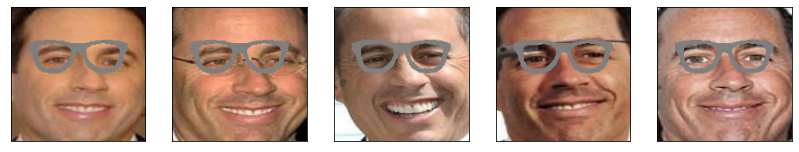

In [ ]:
f, ax= plt.subplots(1, 5, figsize=(14, 4))
for i in range(5):
  ax[i].imshow(adv_sample0[i+5])
  ax[i].set_xticks([]); ax[i].set_yticks([])
plt.show()

In [ ]:
adv_feature= model.predict(X_ex)
df_adv= pd.DataFrame(adv_feature)

In [ ]:
adv_modified_feature0= model.predict(adv_sample0)
df_adv_modify0= pd.DataFrame(adv_modified_feature0)

adv_modified_feature1= model.predict(adv_sample1)
df_adv_modify1= pd.DataFrame(adv_modified_feature1)

In [ ]:
target_feature= model.predict(Target_samples)
df_target= pd.DataFrame(target_feature)

In [ ]:
df_adv['target']= 'Adversarial_sample'
df_adv_modify0['target']= 'Adversarial Pubertation initial step'
df_adv_modify1['target']= 'Adversarial Pubertation final step'
df_target['target']= 'Target_sample'

df=pd.concat([df_target, df_adv_modify0,df_adv_modify1,  df_adv], ignore_index= True)
df.shape

(213, 129)

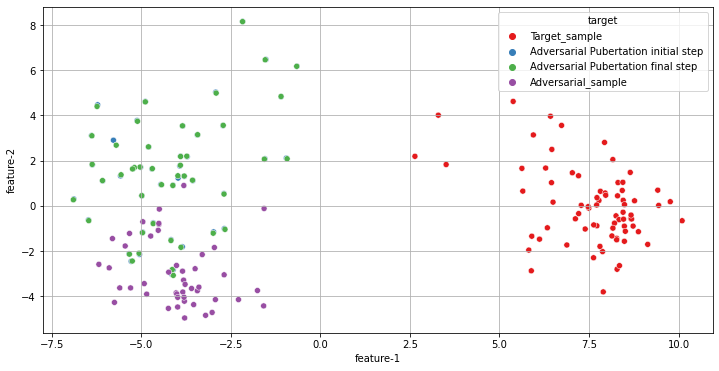

In [ ]:
pca = PCA(n_components=2) 
# Fit pca to 'X'
df1= pd.DataFrame(pca.fit_transform(df.drop(['target'], 1)))
df1.shape

df1['target']= df.target

fig, ax = plt.subplots(figsize=(12, 6))
plt.grid(True)
plt.xlabel('feature-1'); plt.ylabel('feature-2')
sns.scatterplot(x=df1.iloc[:, 0] , y= df1.iloc[:, 1], hue = df1.iloc[:, 2], data= df1, palette='Set1', ax= ax)
plt.show()

In [ ]:
np.save('Benchmark_RDM.npy', HIS) 